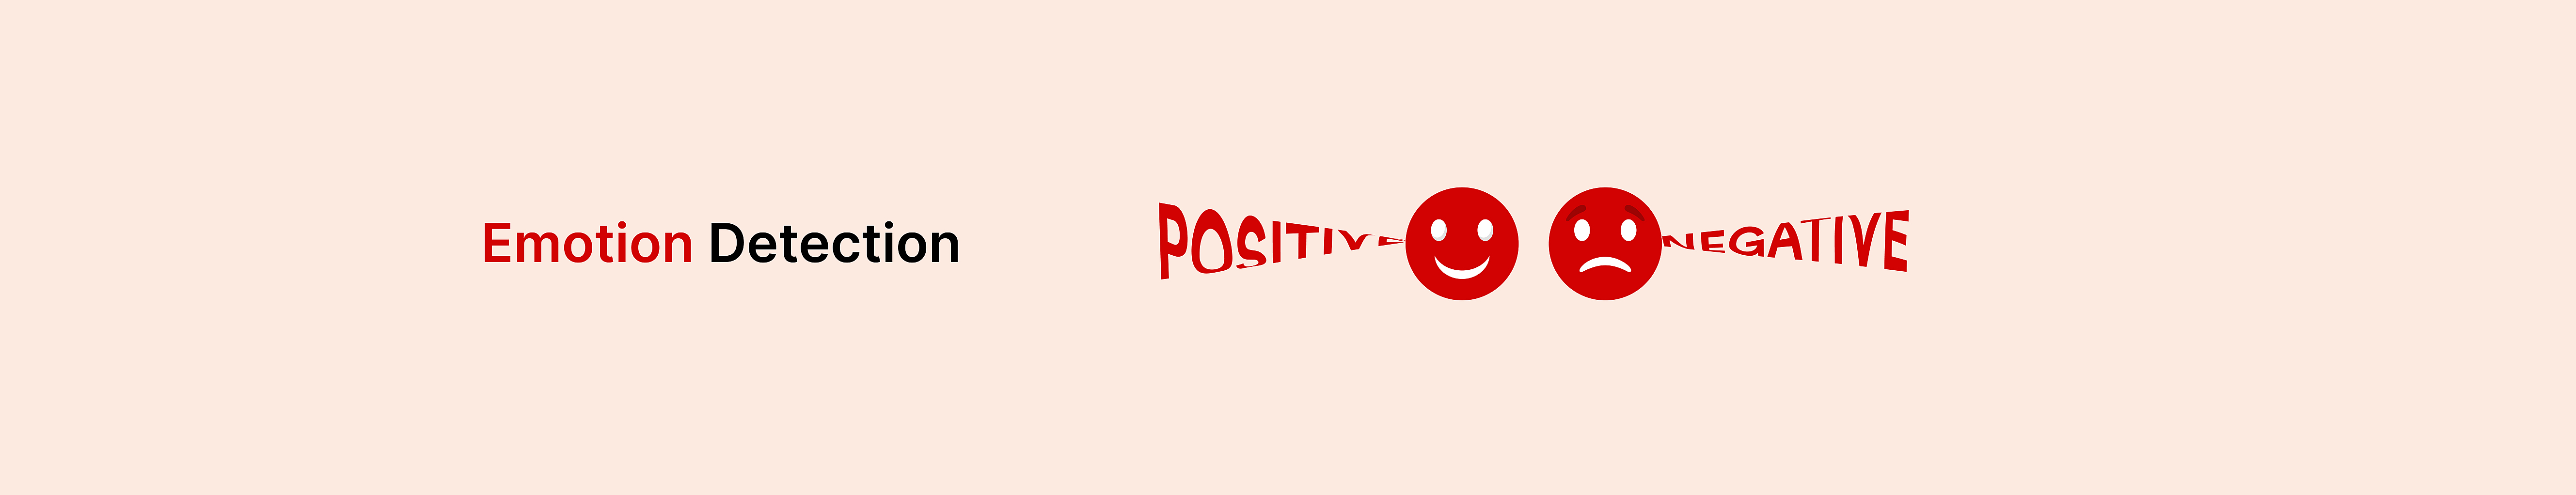


<h2><center>In-Depth Code for Emotion Detection</center></h2>



### What we are going to Learn

  - Alomst all technique to preprocess the nlp task
  - Using tf-idf for converting text to vectors
  - Using Catboost Classifier from sklearn to train, validate & test the  model for text classification.it generally do well for imbalance dataset.
  - Testing and Submitting the Results to the Challenge. 


### Downloading Dataset

AIcrowd had a recent addition that allows you to directly download the dataset from any challenge using AIcrowd CLI. 

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [1]:
!pip install aicrowd-cli

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 215kB 9.4MB/s 
     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 174kB 9.4MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
API_KEY =  # Please get your your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [3]:
# Downloading the Dataset
!mkdir data
!aicrowd dataset download --challenge emotion-detection -j 3 -o data

train.csv:   0% 0.00/2.30M [00:00<?, ?B/s]
test.csv:   0% 0.00/642k [00:00<?, ?B/s]

val.csv:   0% 0.00/262k [00:00<?, ?B/s]

val.csv: 100% 262k/262k [00:00<00:00, 971kB/s]
train.csv: 100% 2.30M/2.30M [00:00<00:00, 4.61MB/s]

test.csv: 100% 642k/642k [00:00<00:00, 1.75MB/s]


### Downloading & Importing Libraries

Here we are going to use spaCy to do our text classification task, now [spaCy](https://spacy.io/) is a very popular python library for Natural Language Processing and got one of the beautiful documentation I have ever seen 😇 and they also got the [Advance NLP with spaCy](https://course.spacy.io/en/) if anyone want's to check out, but back on the topic.   

We are also downloading a python file `explacy.py` from [tylerneylon/explacy](https://github.com/tylerneylon/explacy) which will help us in  visualizing some topics of NLP 

In [4]:
!pip install --upgrade spacy rich
!python -m spacy download en_core_web_sm # Downloaing the model for engligh language will contains many pretrained preprocessing pipelines 

     |████████████████████████████████| 12.8MB 236kB/s 
Requirement already up-to-date: rich in /usr/local/lib/python3.7/dist-packages (10.4.0)
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 624kB 34.6MB/s 
     |████████████████████████████████| 9.1MB 35.6MB/s 
     |████████████████████████████████| 460kB 33.9MB/s 
     |████████████████████████████████| 122kB 38.6MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107107 sha256=dc9b03eca02d4e0f3f43bcb1b8fbff049f5e54b125705d57dda16315f7102fa8
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: smart-open 5.1.0
    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-5.1.0
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing insta

In [5]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

--2021-06-21 04:10:36--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py’

explacy.py          100%[===================>]   6.73K  --.-KB/s    in 0s      

2021-06-21 04:10:36 (32.3 MB/s) - ‘explacy.py’ saved [6896/6896]



In [6]:
!pip install catboost

     |████████████████████████████████| 69.2MB 44kB/s 


In [7]:
!pip install contractions

     |████████████████████████████████| 286kB 5.1MB/s 
     |████████████████████████████████| 327kB 19.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85412 sha256=797727feacc33ea360dad395f5f07508ed27bd1c6e9c4e830ef66014ae49b489
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [8]:
# Importing Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,\
GradientBoostingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier,\
AdaBoostClassifier,StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score

import spacy
import contractions
from bs4 import BeautifulSoup
import unicodedata
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score,roc_curve
# To make things more beautiful! 
import random
from rich.console import Console
from rich.table import Table
from rich import pretty
pretty.install()


# Seeding everything for getting same results 
random.seed(1)
spacy.util.fix_random_seed(1)


# function to display YouTube videos
from IPython.display import YouTubeVideo

In [9]:
# spaCy v3.0 the the latest version spaCy 
spacy.__version__

'3.0.6'

### Reading Dataset

Reading the necessary files to train, validation & submit our results! 

In [10]:
train_dataset = pd.read_csv("data/train.csv")
validation_dataset = pd.read_csv("data/val.csv")
test_dataset = pd.read_csv("data/test.csv")
train_dataset.head()

,text,label
0,takes no time to copy/paste a press release,0
1,You're delusional,1
2,Jazz fan here. I completely feel. Lindsay Mann...,0
3,ah i was also confused but i think they mean f...,0
4,Thank you so much. ♥️ that means a lot.,0


In [11]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31255 entries, 0 to 31254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31255 non-null  object
 1   label   31255 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 488.5+ KB


In [12]:
validation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3473 entries, 0 to 3472
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3473 non-null   object
 1   label   3473 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.4+ KB


In [13]:
#trainplusval=pd.concat([train_dataset,validation_dataset])

In [14]:
#trainplusval.info()

In [15]:
#trainplusval.head()

In [16]:
test_dataset = pd.read_csv("data/test.csv")

# Text Preprocessing 🏭

Now, computers just can't understand texts, those texts need to be converted into numbers for computers to understand, and before converting to numbers, we also need to *clean our texts*, remove unnecessary letters, punctunations, special characters and much much more. So let's see in more detail what I mean.  

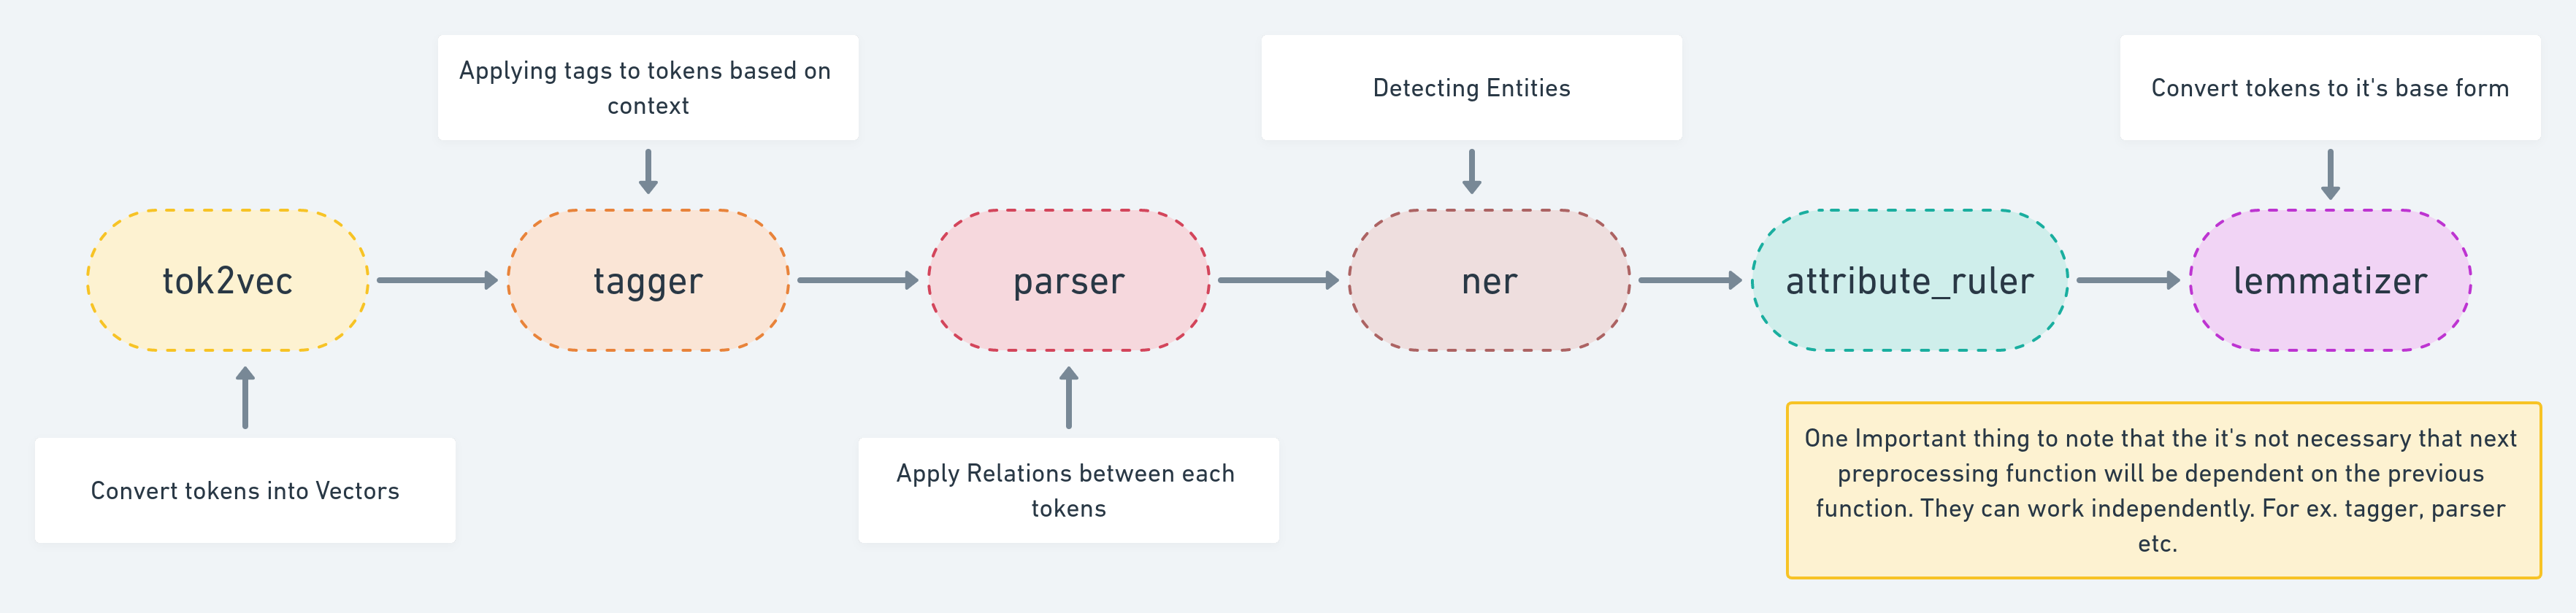

In [17]:
def DealMissing(df,col):
    df[col]=df[col].fillna(' '+'Null')
    return df

def LowerCase(df,col):
    df[col]=df[col].apply(lambda x:str(x).lower())
    return df

#contraction to expansion  (I'll: I Will)
def cont2expansion(df,col):
    def Cont2Exp(x):
        if type(x) is str:
            a=[]
            for word in x.split():
                a.append(contractions.fix(word))
            expanded_text = ' '.join(a)
            return expanded_text
        else:
            return x
    df[col]=df[col].apply(lambda x:Cont2Exp(x))
    return df

#Removing Emails from the dataset
def Remove_Emails(df,col):
    import re
    df[col]=df[col].apply(lambda x:re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+._-]+)',"",x))
    return df

#removing urls
def Remove_urls(df,col):
    import re
    df[col]=df[col].apply(lambda x:(re.sub(r'(http|https|ftp|ssh://([\w_-]+(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','',x)))
    return df

#remove rt from the begining
def Remove_rt(df,col):
    import re
    df[col]=df[col].apply(lambda x:(re.sub(r'\brt\b','',x)))
    return df


#Remove Special Characters
def Remove_SpecialChar(df,col):
    import re
    df[col]=df[col].apply(lambda x:re.sub(r'[^\w ]+',"",x))
    return df

#Remove Numeric
def Remove_Numeric(df,col):
    import re
    df[col]=df[col].apply(lambda x:re.sub(r'[0-9]','',x))
    return df

#Remove Extra Spaces
def Remove_ExtraSpaces(df,col):
    df[col]=df[col].apply(lambda x:' '.join(x.split()))
    return df

#Remove HTML Tags
def Remove_HTMLTags(df,col):
    df[col]=df[col].apply(lambda x:BeautifulSoup(x, 'lxml').get_text().strip())
    return df

# Remove Accented Char
def Remove_AccentedChar(df,col):
    import unicodedata
    def RemoveAccentedChar(x):
        x=unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8','ignore')
        return x
    df[col]=df[col].apply(lambda x:RemoveAccentedChar(x))
    return df

#Removing StopWords
def Remove_StopWords(df,col):
    df[col]=df[col].apply(lambda x: ' '.join([t for t in x.split() if t not in STOP_WORDS]))
    return df
    
# Covert text to it's base form (Lemmatizing)
def Convert2Base(df,col):
    import spacy
    nlp=spacy.load('en_core_web_sm')
    def make_to_base(x):
        x=str(x)
        x_list=[]
        doc=nlp(x)

        for token in doc:
            lemma=token.lemma_
            if lemma=='-PRON-' or lemma=='be':
                lemma=token.text
            x_list.append(lemma)
        return ' '.join(x_list)
    df[col]=df[col].apply(lambda x:make_to_base(x))
    return df

#Removing Most occuring words
def Remove_MostOccuring(df,col):
    text=' '.join(df[col])
    text=text.split()
    freq_comm=pd.Series(text).value_counts()
    f2=freq_comm[:4]
    df[col]=df[col].apply(lambda x:' '.join([t for t in x.split() if t not in f2]))
    return df

#Removing Rarely occuring words
def Remove_RarelyOccuring(df,col):
    text=' '.join(df[col])
    text=text.split()
    freq_comm=pd.Series(text).value_counts()
    rare10000=freq_comm.tail(10000)
    df[col]=df[col].apply(lambda x:' '.join([t for t in x.split() if t not in rare10000]))
    return df

# Remove Blank tweet 
def Remove_Blank(df,col):
    a=df[col].apply(lambda x:len(x.split()))
    df_filtered=df[a==0]
    df.drop(df_filtered.index, inplace = True)
    return df



## Preprocessing the train data

In [18]:
def Preprocess_text(df,col,text=True):
    df=DealMissing(df,col)
    df=LowerCase(df,col)
    df=cont2expansion(df,col)
    df=Remove_Emails(df,col)
    df=Remove_urls(df,col)
    df=Remove_rt(df,col)
    df=Remove_SpecialChar(df,col)
    df=Remove_Numeric(df,col)
    df=Remove_ExtraSpaces(df,col)
    df=Remove_HTMLTags(df,col)
    df=Remove_AccentedChar(df,col)
    df=Remove_StopWords(df,col)
    df=Convert2Base(df,col)
    if text:
        #df=Remove_MostOccuring(df,col)   #Vary with data
        #df=pu.Remove_RarelyOccuring(df,col)  #Vary with data
        df=Remove_Blank(df,col)
        print('Main Text')
    return df

In [19]:
train_dataset=Preprocess_text(train_dataset,col='text')

Main Text


In [20]:
validation_dataset=Preprocess_text(validation_dataset,col='text')

Main Text


In [21]:
test_dataset=Preprocess_text(test_dataset,col='text',text=False)

## Balancing Data

<matplotlib.axes._subplots.AxesSubplot object at 0x7fa995292850>

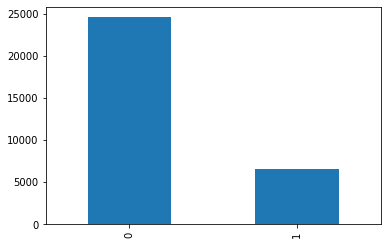

In [22]:
train_dataset['label'].value_counts().plot(kind='bar')

In [23]:
print(train_dataset['label'].value_counts())

0    24564
1     6520
Name: label, dtype: int64


In [24]:
#train_dataset_=train_dataset.copy()

In [25]:
#train_dataset=train_dataset_.copy()

In [26]:
#seed=2021

In [27]:
#target_col = "label"

In [28]:
#target_values = [0,1]

In [29]:
#fraction=0.6

In [30]:
#df_pos = train_dataset[train_dataset[target_col].isin(target_values[1:])]
#nb_pos = df_pos.shape[0]
#nb_neg = nb_pos*fraction
#df_neg = train_dataset[train_dataset[target_col] == 0].sample(n=int(nb_neg), random_state=seed)
#df_samples = pd.concat([df_pos, df_neg]).sample(frac=1).reset_index(drop=True)

In [31]:
#df_samples['label'].value_counts().plot(kind='bar')

In [32]:
#train_dataset=df_samples.copy()

## Converting into vectors

In [33]:
# Getting the vector from the sample text
tf_idf=TfidfVectorizer()
X_train=tf_idf.fit_transform(train_dataset['text'])
X_train=X_train.toarray()
y_train=train_dataset['label']
y_train=np.array(y_train)

In [34]:

X_val=tf_idf.transform(validation_dataset['text'])
X_val=X_val.toarray()
y_val=validation_dataset['label']
y_val=np.array(y_val)


In [35]:
X_test=tf_idf.transform(test_dataset['text'])
X_test=X_test.toarray()
y_test=test_dataset['label']


## Validation

In [36]:
def evaluate_model(clf,X,y):
    skf =StratifiedKFold(n_splits=5,shuffle=True)
    scores=cross_val_score(clf,X,y,cv=skf,verbose=3,n_jobs=-1)
    return scores

## Checking models  (Run this only if have high amount of RAM)

In [37]:
def getmodels():
    model=dict()
    model['Rf']=RandomForestClassifier()
    model['gb']=GradientBoostingClassifier()
    model['xgb']=XGBClassifier()
    model['catboost']=CatBoostClassifier(verbose=False)
    model['et']=ExtraTreesClassifier()
    model['lr']=LogisticRegression()
    model['bayes`']=GaussianNB()
    return model

In [ ]:
# get the models to evaluate

models=getmodels()
# evaluate the model and store the results
results,names=list(),list()
for name,model in models.items():
    scores=evaluate_model(model,X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)'%(name,np.mean(scores),np.std(scores)))
plt.boxplot(results,labels=names,showmeans=True)
plt.show

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


## Creating the Model

Now we are getting close. Here we are using [sklearn](https://scikit-learn.org/stable/) ( A popular Machine Learning Library ) Decision Tree Classifier model to classifty our text ( vectors ) into 2 labels.  

In [36]:
clf = CatBoostClassifier(verbose=True,early_stopping_rounds = 200)


## Training

And there we go! It's finally the time to start the training!

In [37]:
clf = clf.fit(X_train, y_train)

Learning rate set to 0.044694
0:	learn: 0.6753215	total: 352ms	remaining: 5m 51s
1:	learn: 0.6589532	total: 585ms	remaining: 4m 51s
2:	learn: 0.6443473	total: 817ms	remaining: 4m 31s
3:	learn: 0.6291774	total: 1.05s	remaining: 4m 21s
4:	learn: 0.6168380	total: 1.29s	remaining: 4m 15s
5:	learn: 0.6060238	total: 1.53s	remaining: 4m 13s
6:	learn: 0.5951827	total: 1.76s	remaining: 4m 9s
7:	learn: 0.5848371	total: 2s	remaining: 4m 7s
8:	learn: 0.5753775	total: 2.23s	remaining: 4m 5s
9:	learn: 0.5674846	total: 2.47s	remaining: 4m 4s
10:	learn: 0.5597334	total: 2.7s	remaining: 4m 3s
11:	learn: 0.5528915	total: 2.94s	remaining: 4m 2s
12:	learn: 0.5454608	total: 3.18s	remaining: 4m 1s
13:	learn: 0.5395754	total: 3.43s	remaining: 4m 1s
14:	learn: 0.5341089	total: 3.66s	remaining: 4m
15:	learn: 0.5290430	total: 3.9s	remaining: 3m 59s
16:	learn: 0.5240239	total: 4.13s	remaining: 3m 58s
17:	learn: 0.5200620	total: 4.37s	remaining: 3m 58s
18:	learn: 0.5167559	total: 4.61s	remaining: 3m 57s
19:	learn

In [38]:
def BestThreshold(y_test,pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
    roc_auc_score_ = []
    for thres in thresholds:
        y_pred = np.where(pred_prob>thres,1,0)
        roc_auc_score_.append(f1_score(y_test, y_pred))

    roc_auc_score_ = pd.concat([pd.Series(thresholds), pd.Series(roc_auc_score_)],
                            axis=1)
    roc_auc_score_.columns = ['thresholds', 'f1_score']
    roc_auc_score_.sort_values(by='f1_score', ascending=False, inplace=True)
    return roc_auc_score_.head()

## Validation

Now we have trained the model, let's see the results for unseen validation dataset. 

In [39]:
pred_prob = clf.predict_proba(X_val)[:,1]

In [40]:
topthres=BestThreshold(y_val,pred_prob)
topthres

,thresholds,f1_score
413,0.197416,0.580645
409,0.198505,0.580330
414,0.197156,0.580292
411,0.197916,0.580134
410,0.198406,0.579976


In [41]:
y_pred = np.where(pred_prob>0.197416,1,0)

In [42]:
# Getting F1 & Accuracy score of validation predictions
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

print(f"Validation F1 Score  : {f1} and Accuracy Score {accuracy}")

Validation F1 Score  : 0.5802919708029197 and Accuracy Score 0.8002316155182397


# Submitting Results 📄

Okay, this is the last section 😌 , let's get out testing results from the model real quick and submit our prediction directly using AIcrowd CLI

In [45]:
# By settings is_train=False, the create_data function will only output the features as setuped in the function
pred_prob_test = clf.predict_proba(X_test)[:,1]
#test_predictions = clf.predict(test_data)
test_predictions=np.where(pred_prob_test>0.197416,1,0)

In [46]:
len(test_predictions)

8682

In [47]:
# Applying the predictions to the labels column of the sample submission 
test_dataset['label'] = test_predictions
test_dataset

,text,label
0,edge cassie zamora show disdain terrible indiv...,1
1,think right oodle cash young grandchild enjoy ...,0
2,haha love phone book room look like matter hou...,0
3,probably desperation go answer god,0
4,sorry real good,1
...,...,...
8677,yeah noi find demeaning,0
8678,mafia work,0
8679,ah thank,0
8680,ask straight respect decision usually fix,0



**Note : Please make sure that there should be filename `submission.csv` in `assets` folder before submitting it**

In [48]:
import os

In [49]:
# Saving the sample submission in assets directory
!mkdir assets
test_dataset.to_csv(os.path.join("assets", "submission.csv"), index=False)

## Uploading the Results 
**Note : Please save the notebook before submitting it (Ctrl + S)**

In [50]:
!aicrowd notebook submit -c emotion-detection -a assets --no-verify

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5qWv6r0DgToK5pgwyJobhb3YYc9ST5AsPjz9eWtp9-Pl15owVCmwg
Mounted at /content/drive
Using notebook: /content/drive/MyDrive/Colab Notebooks/Emotion_Detection for submission...
Scrubbing API keys from the notebook...
su

Congratulations 🎉 you did it, but there still a lot of improvement that can be made, data exploration is one of the most import pipelines in machine learning, especially in competitions, so maybe see if there is data imbalance (Have discussed in this notebook that how can you do that although i have commented that portion, you can try with different model), how minimize it's effects, maybe looking first few rows to each dataset. Or maybe improving the score, have fun!
